## DeepFake Detection Deep Learning Model Based on PyTorch & CNN Architecture


## 1. Imports and Dependencies


In [ ]:

import numpy as np 
import pandas as pd 
import os
import sys
import time
from collections import defaultdict

import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import plotly.graph_objs as go
from plotly.offline import iplot
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_theme(style='whitegrid', palette='viridis', font_scale=1.2)

import warnings
warnings.filterwarnings('ignore')

## 2. Checking System Configurations


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✅ GPU is available: {torch.cuda.get_device_name(0)}")
    print(f"🔸 Number of GPUs: {torch.cuda.device_count()}")
else:
    device = torch.device("cpu")
    print("⚠️ No GPU available. Using CPU.")
print(f"🔸 PyTorch Version: {torch.__version__}")

✅ GPU is available: NVIDIA GeForce RTX 3060 Ti
🔸 Number of GPUs: 1
🔸 PyTorch Version: 2.2.2+cu121


## 3. Load Data


In [ ]:
def get_data():
    return pd.read_csv("metadata.csv")


meta = get_data()
meta.head()

## 4. Exploratory Data Analysis

### 4.1. Metadata Summary


In [5]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=["dtypes"])
    summary_df["count"] = df.count().values
    summary_df["unique"] = df.nunique().values
    summary_df["missing#"] = df.isna().sum()
    summary_df["missing%"] = df.isna().sum() / len(df)
    return summary_df


summary(meta).style.background_gradient("Purples")

In [6]:
print("Fake Images:", len(meta[meta.label == "FAKE"]))
print("Real Images:", len(meta[meta.label == "REAL"]))

Fake Images: 79341
Real Images: 16293


### 4.2. Real / Fake Data Distribution Normailzation


In [ ]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 16000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

### 4.3. Training / Validation / Testing Sets


In [ ]:
Train_set, Test_set = train_test_split(
    sample_meta, test_size=0.2, random_state=42, stratify=sample_meta["label"]
)
Train_set, Val_set = train_test_split(
    Train_set, test_size=0.3, random_state=42, stratify=Train_set["label"]
)

print(f"Train Set: {Train_set.shape}")
print(f"Validation Set: {Val_set.shape}")
print(f"Test Set: {Test_set.shape}")

Train Set: (17920, 5)
Validation Set: (7680, 5)
Test Set: (6400, 5)


### 4.4. Display sample of images from Dataset


In [ ]:
plt.figure(figsize=(15, 15), dpi=300)
for idx, i in enumerate(Train_set.index[75:100]):
    plt.subplot(5, 5, idx + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = cv2.imread("faces_224/" + Train_set.loc[i, "videoname"][:-4] + ".jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

    plt.xlabel("FAKE Image" if Train_set.loc[i, "label"] == "FAKE" else "REAL Image")

plt.tight_layout()
plt.show()

### 4.5. X / y Splitting of Sets


In [ ]:

def retrieve_dataset(set_name):
    images, labels = [], []
    for img, imgclass in zip(set_name["videoname"], set_name["label"]):
        images.append(cv2.imread("Dataset/" + img[:-4] + ".jpg"))
        labels.append(1 if imgclass == "FAKE" else 0)
    return np.array(images), np.array(labels)

In [12]:
%%time

X_train, y_train = retrieve_dataset(Train_set)
X_val, y_val = retrieve_dataset(Val_set)
X_test, y_test = retrieve_dataset(Test_set)

CPU times: total: 15.8 s
Wall time: 1min 40s


## 5. Model Training

### 5.1. Data Preprocessing


In [ ]:
%%time

torch.cuda.empty_cache()
torch.manual_seed(42)
np.random.seed(42)

batch_size = 16

class DeepfakeDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10), 
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)), 
    transforms.ColorJitter(contrast=0.1), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = DeepfakeDataset(X_train, y_train, transform=train_transform)
val_dataset = DeepfakeDataset(X_val, y_val, transform=val_transform)
test_dataset = DeepfakeDataset(X_test, y_test, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 1120
Validation batches: 480
Test batches: 400
CPU times: total: 62.5 ms
Wall time: 144 ms


### 5.2. Building the model Architecture


In [ ]:
%%time

class DeepfakeDetector(nn.Module):
    def __init__(self, num_classes=1):
        super(DeepfakeDetector, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b4')
        num_features = self.base_model._fc.in_features
        self.base_model._fc = nn.Sequential(
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.base_model(x)

model = DeepfakeDetector(num_classes=1)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = nn.BCELoss()

# Print model summary
print(f"Model loaded on: {device}")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Loaded pretrained weights for efficientnet-b4
Model loaded on: cuda
Total parameters: 17,550,409
Trainable parameters: 17,550,409
CPU times: total: 797 ms
Wall time: 396 ms


### 5.3. Model Fitting with Training & Validation Sets


In [ ]:
%%time

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

epochs = 25
history = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
}

best_val_acc = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 30)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'spatial_model.pth')
        print(f"✅ Best model saved with Val Acc: {val_acc:.4f}")

print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.4f}")


Epoch 1/25
------------------------------


Validation: 100%|██████████| 480/480 [00:26<00:00, 18.08it/s]


Train Loss: 0.5875 - Train Acc: 0.6877
Val Loss: 0.4870 - Val Acc: 0.7552
✅ Best model saved with Val Acc: 0.7552

Epoch 2/25
------------------------------


Validation: 100%|██████████| 480/480 [00:26<00:00, 18.06it/s]


Train Loss: 0.4384 - Train Acc: 0.7951
Val Loss: 0.3549 - Val Acc: 0.8419
✅ Best model saved with Val Acc: 0.8419

Epoch 3/25
------------------------------


Validation: 100%|██████████| 480/480 [00:26<00:00, 18.12it/s]


Train Loss: 0.3523 - Train Acc: 0.8374
Val Loss: 0.3412 - Val Acc: 0.8503
✅ Best model saved with Val Acc: 0.8503

Epoch 4/25
------------------------------


Validation: 100%|██████████| 480/480 [00:26<00:00, 18.00it/s]


Train Loss: 0.2873 - Train Acc: 0.8747
Val Loss: 0.2858 - Val Acc: 0.8773
✅ Best model saved with Val Acc: 0.8773

Epoch 5/25
------------------------------


Validation: 100%|██████████| 480/480 [00:28<00:00, 16.79it/s]


Train Loss: 0.2493 - Train Acc: 0.8918
Val Loss: 0.3624 - Val Acc: 0.8579

Epoch 6/25
------------------------------


Validation: 100%|██████████| 480/480 [00:28<00:00, 16.73it/s]


Train Loss: 0.2204 - Train Acc: 0.9122
Val Loss: 0.2549 - Val Acc: 0.8896
✅ Best model saved with Val Acc: 0.8896

Epoch 7/25
------------------------------


Validation: 100%|██████████| 480/480 [00:26<00:00, 18.42it/s]


Train Loss: 0.1890 - Train Acc: 0.9238
Val Loss: 0.2468 - Val Acc: 0.9003
✅ Best model saved with Val Acc: 0.9003

Epoch 8/25
------------------------------


Validation: 100%|██████████| 480/480 [00:27<00:00, 17.74it/s]


Train Loss: 0.1746 - Train Acc: 0.9315
Val Loss: 0.2584 - Val Acc: 0.9020
✅ Best model saved with Val Acc: 0.9020

Epoch 9/25
------------------------------


Validation: 100%|██████████| 480/480 [00:28<00:00, 16.83it/s]


Train Loss: 0.1464 - Train Acc: 0.9438
Val Loss: 0.3628 - Val Acc: 0.8617

Epoch 10/25
------------------------------


Validation: 100%|██████████| 480/480 [00:28<00:00, 16.93it/s]


Train Loss: 0.1334 - Train Acc: 0.9491
Val Loss: 0.3549 - Val Acc: 0.8879

Epoch 11/25
------------------------------


Validation: 100%|██████████| 480/480 [00:29<00:00, 16.52it/s]


Train Loss: 0.1221 - Train Acc: 0.9522
Val Loss: 0.2862 - Val Acc: 0.8984

Epoch 12/25
------------------------------


Validation: 100%|██████████| 480/480 [00:28<00:00, 16.95it/s]


Train Loss: 0.1098 - Train Acc: 0.9608
Val Loss: 0.3480 - Val Acc: 0.8665

Epoch 13/25
------------------------------


Validation: 100%|██████████| 480/480 [00:28<00:00, 16.96it/s]


Train Loss: 0.1029 - Train Acc: 0.9610
Val Loss: 0.3006 - Val Acc: 0.8941

Epoch 14/25
------------------------------


Validation: 100%|██████████| 480/480 [00:28<00:00, 16.97it/s]


Train Loss: 0.0920 - Train Acc: 0.9656
Val Loss: 0.2968 - Val Acc: 0.9038
✅ Best model saved with Val Acc: 0.9038

Epoch 15/25
------------------------------


Validation: 100%|██████████| 480/480 [00:28<00:00, 16.77it/s]


Train Loss: 0.0830 - Train Acc: 0.9695
Val Loss: 0.2939 - Val Acc: 0.8909

Epoch 16/25
------------------------------


Validation: 100%|██████████| 480/480 [00:29<00:00, 16.53it/s]


Train Loss: 0.0736 - Train Acc: 0.9728
Val Loss: 0.3894 - Val Acc: 0.8958

Epoch 17/25
------------------------------


Validation: 100%|██████████| 480/480 [00:29<00:00, 16.49it/s]


Train Loss: 0.0733 - Train Acc: 0.9723
Val Loss: 0.3098 - Val Acc: 0.8996

Epoch 18/25
------------------------------


Validation: 100%|██████████| 480/480 [00:29<00:00, 16.54it/s]


Train Loss: 0.0593 - Train Acc: 0.9772
Val Loss: 0.3468 - Val Acc: 0.9018

Epoch 19/25
------------------------------


Validation: 100%|██████████| 480/480 [00:28<00:00, 16.61it/s]


Train Loss: 0.0700 - Train Acc: 0.9756
Val Loss: 0.3701 - Val Acc: 0.8878

Epoch 20/25
------------------------------


Validation: 100%|██████████| 480/480 [00:29<00:00, 16.15it/s]


Train Loss: 0.0585 - Train Acc: 0.9790
Val Loss: 0.3408 - Val Acc: 0.8938

Epoch 21/25
------------------------------


Validation: 100%|██████████| 480/480 [00:28<00:00, 16.69it/s]


Train Loss: 0.0495 - Train Acc: 0.9807
Val Loss: 0.3725 - Val Acc: 0.9048
✅ Best model saved with Val Acc: 0.9048

Epoch 22/25
------------------------------


Validation: 100%|██████████| 480/480 [00:28<00:00, 16.61it/s]


Train Loss: 0.0494 - Train Acc: 0.9820
Val Loss: 0.3190 - Val Acc: 0.9158
✅ Best model saved with Val Acc: 0.9158

Epoch 23/25
------------------------------


Validation: 100%|██████████| 480/480 [00:29<00:00, 16.16it/s]


Train Loss: 0.0483 - Train Acc: 0.9831
Val Loss: 0.3073 - Val Acc: 0.9107

Epoch 24/25
------------------------------


Validation: 100%|██████████| 480/480 [00:29<00:00, 16.24it/s]


Train Loss: 0.0503 - Train Acc: 0.9837
Val Loss: 0.3516 - Val Acc: 0.9089

Epoch 25/25
------------------------------


Validation: 100%|██████████| 480/480 [00:28<00:00, 16.82it/s]

Train Loss: 0.0456 - Train Acc: 0.9828
Val Loss: 0.3423 - Val Acc: 0.9090

Training completed! Best validation accuracy: 0.9158
CPU times: total: 14h 10min 44s
Wall time: 1h 49min 43s


## 6. Model Performance Evaluation


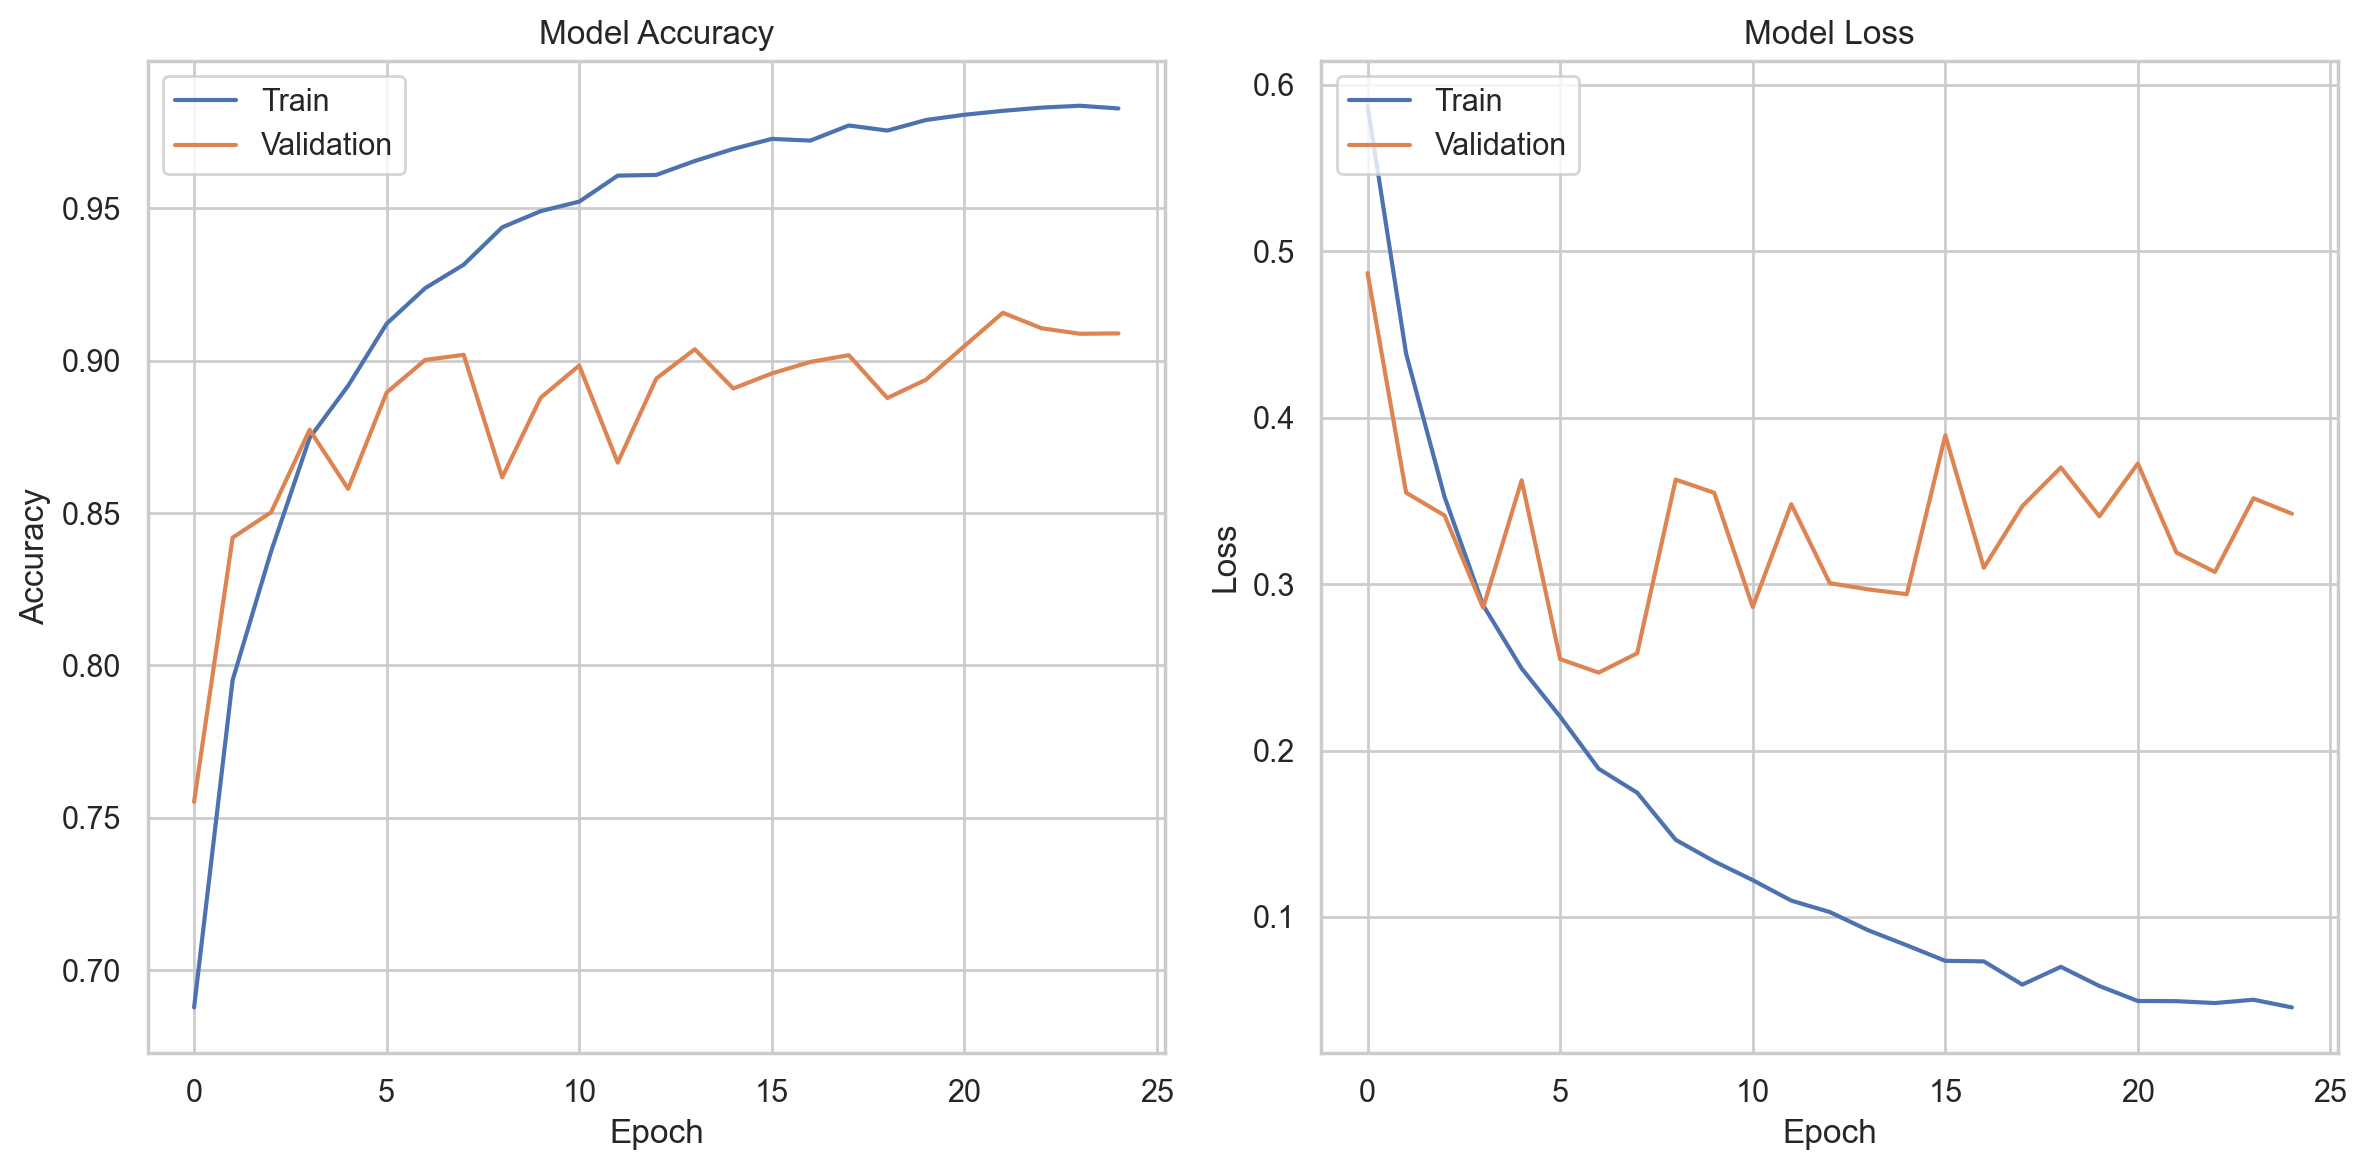

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:
model.load_state_dict(torch.load("spatial_model.pth"))  # Load best model
test_loss, test_accuracy = validate_epoch(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Validation: 100%|██████████| 400/400 [00:25<00:00, 15.61it/s]


Test Loss: 0.3083
Test Accuracy: 0.9211


Predicting: 100%|██████████| 400/400 [00:25<00:00, 15.74it/s]


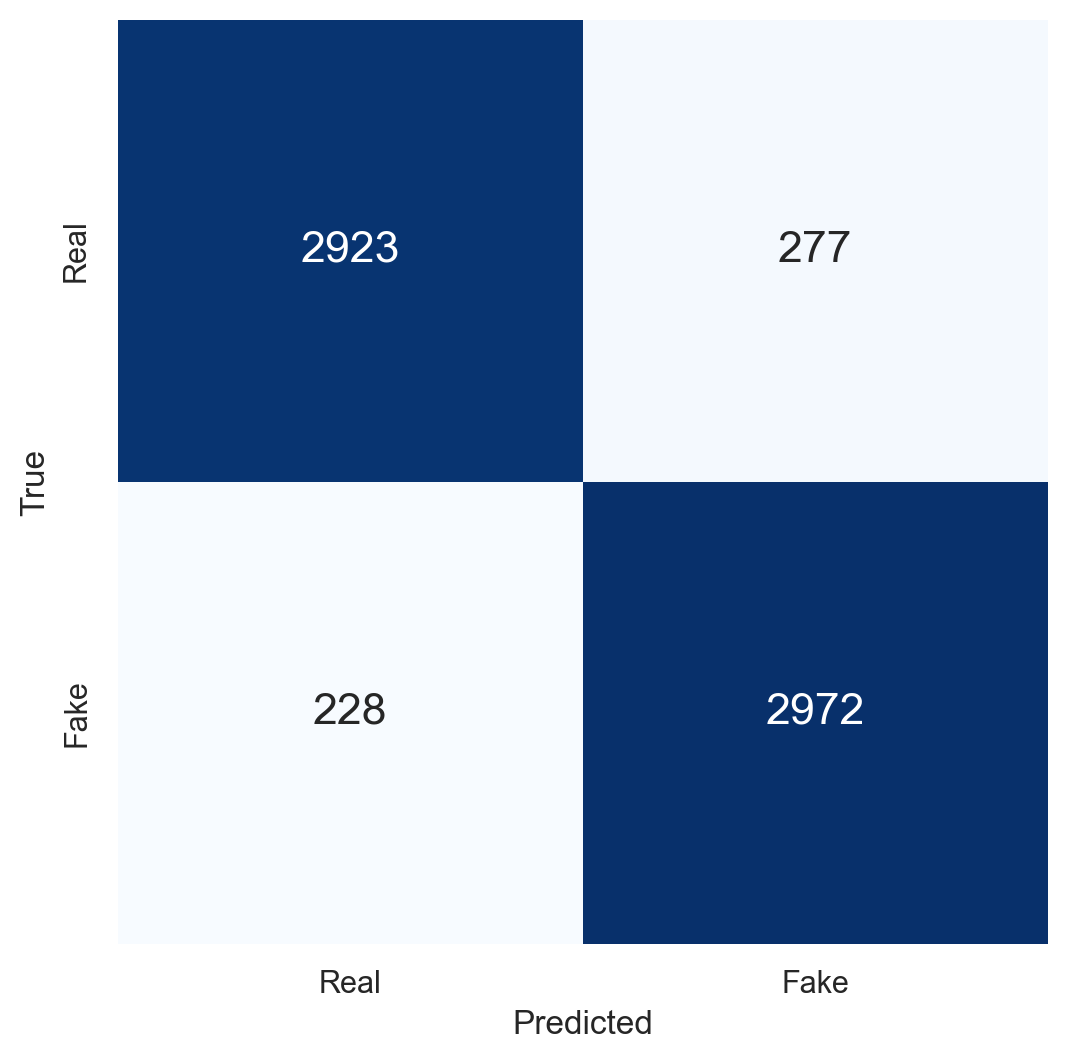

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Predicting"):
        images = images.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).cpu().numpy().astype(int)
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.numpy().astype(int))

y_pred = np.array(all_preds)
y_true = np.array(all_labels)

conf_mat = confusion_matrix(y_true, y_pred, labels=[0, 1])

plt.figure(figsize=(6, 6))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    annot_kws={"size": 16},
    xticklabels=["Real", "Fake"],
    yticklabels=["Real", "Fake"],
)
 
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3200
           1       0.91      0.93      0.92      3200

    accuracy                           0.92      6400
   macro avg       0.92      0.92      0.92      6400
weighted avg       0.92      0.92      0.92      6400



## 7. Save Final Model


In [ ]:
torch.save(model.state_dict(), "spatial_model.pth")
print("Model saved as 'spatial_model.pth'")

Model saved as 'redeepfake_model.pth'


## 8. Model Reusing Guide


In [ ]:
model_path = "spatial_model.pth"

model = DeepfakeDetector(num_classes=1)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()
print("Model loaded successfully!")

Loaded pretrained weights for efficientnet-b4
Model loaded successfully!


In [ ]:
inference_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


def preprocess_image(image_path):

    img = cv2.imread(image_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = inference_transform(img)

    return img

In [ ]:
test_image_paths = []
for idx, i in enumerate(Test_set.index[125:150]):
    test_image_paths.append(
        (
            "Dataset/"
            + Test_set.loc[i, "videoname"][:-4]
            + ".jpg",
            Test_set.loc[i, "label"],
        )
    )

In [ ]:
plt.figure(figsize=(15, 15), dpi=300)

model.eval()
with torch.no_grad():
    for idx, (image_path, label) in enumerate(test_image_paths):
        processed_image = preprocess_image(image_path)
        processed_image = processed_image.unsqueeze(0).to(device)  
        prediction = model(processed_image)
        pred_value = prediction.cpu().numpy()[0, 0]

        predicted_class = "FAKE" if pred_value > 0.33 else "REAL"

        plt.subplot(5, 5, idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)

        plt.xlabel(
            f'{predicted_class} | {pred_value:.2f} | {"T" if predicted_class == label else "F"}'
        )

plt.tight_layout()
plt.show()